# BaggingClassifier

In [1]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from sklearn.datasets import load_breast_cancer
dataset=load_breast_cancer()
x=dataset.data
y=dataset.target

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x,y,random_state=4)

In [4]:
knn=KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.8951048951048951

Let's use bagging over KNN classifier and see if our score improves:

In [5]:
bag_knn= BaggingClassifier(KNeighborsClassifier(n_neighbors=5),
                          n_estimators=9, max_samples=0.7,
                          bootstrap=True, random_state=3,oob_score=True)

In [6]:
bag_knn.fit(x_train,y_train)
bag_knn.score(x_test,y_test)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\USER\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:644: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


0.9020979020979021

Great our score sginificantly improves with use of bagging.

let's not use bootstrap and see the model accuracy! Remember this is "pasting"

In [7]:
pasting_knn= BaggingClassifier(KNeighborsClassifier(n_neighbors=5),
                          n_estimators=9, max_samples=0.7,
                          bootstrap=False, random_state=3)

In [8]:
pasting_knn.fit(x_train,y_train)
pasting_knn.score(x_test,y_test)

0.8881118881118881

# Random Forests

# Problem Statement

To build an application to classify the patients to be healthy or suffering from cardiovascular disease based on the given attributes

In [9]:
#Important Libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing, Normalizing
from sklearn.preprocessing import StandardScaler

#Model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [10]:
df=pd.read_csv('https://raw.githubusercontent.com/training-ml/Files/main/cardio_train.csv',sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [11]:
# Dataset stats
print(df.shape)

(69301, 13)


In [12]:
# All are int and float types. understand the stats of dataframe

df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# How to remove duplicates

In [13]:
#Drop Id and remove duplicates
df.drop('id',axis=1, inplace=True)

#Duplicate removal
df.drop_duplicates(inplace=True)

In [14]:
df.shape

(69277, 12)

In [15]:
pip install seaborn

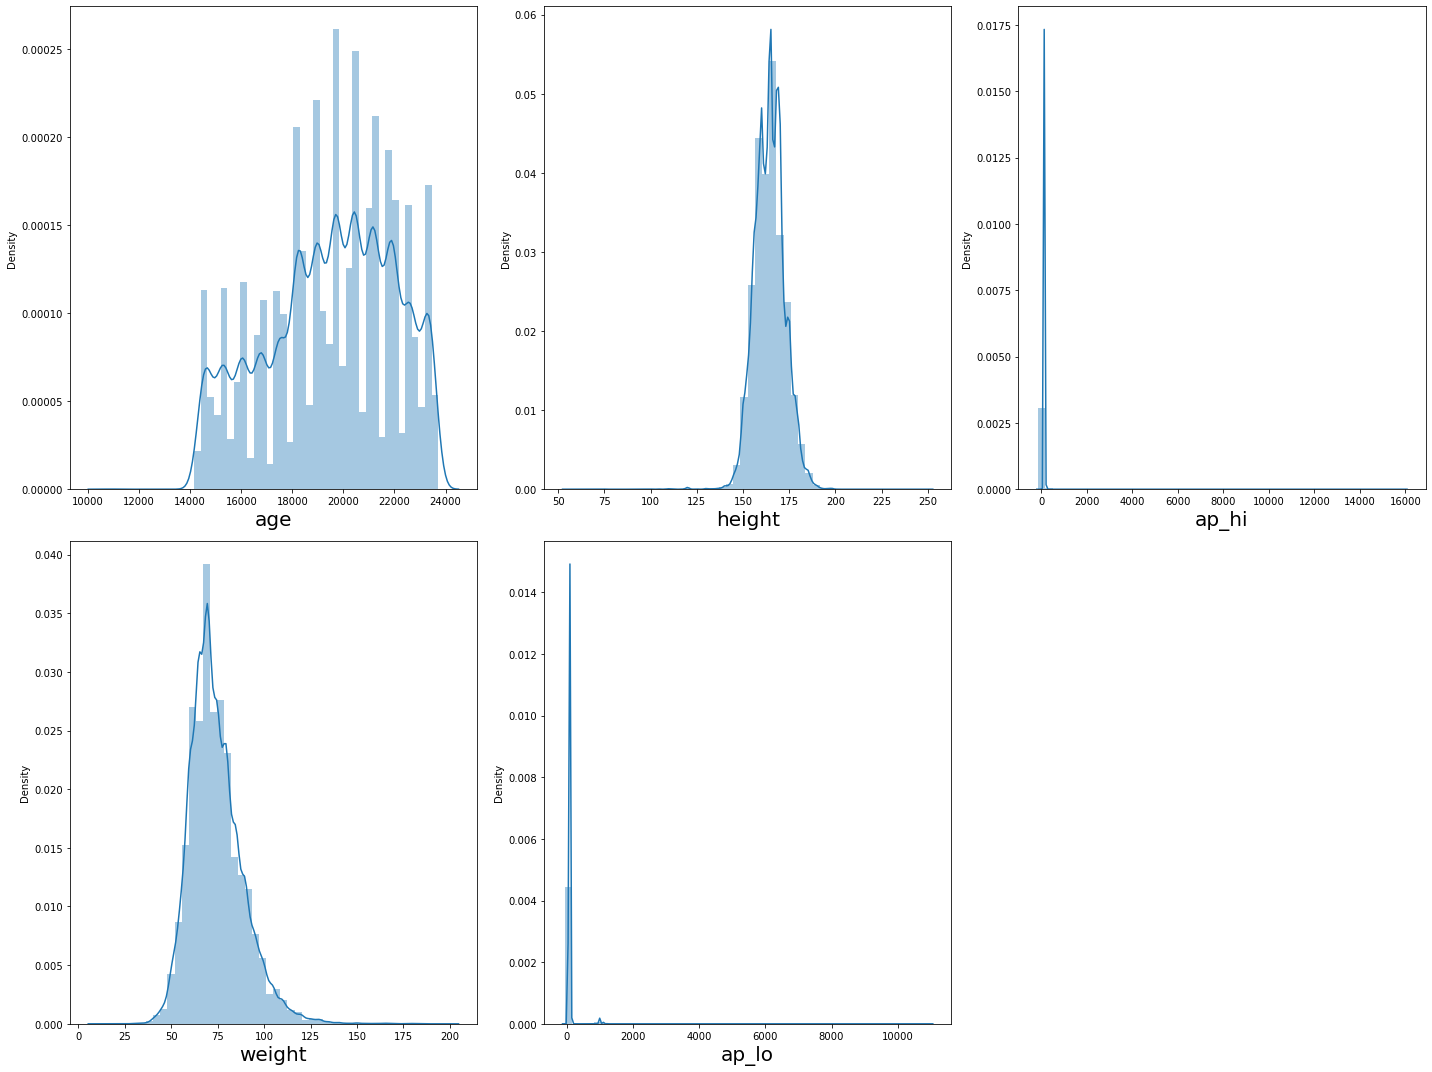

In [16]:
plt.figure(figsize=(20,15))
plotnumber=1

for column in df[['age','height','ap_hi','weight','ap_lo']]:
    if plotnumber<=6:
        ax=plt.subplot(2,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
        
        
    plotnumber+=1
plt.tight_layout()
    

# z=(x-mean)/std

In [19]:
# with std 3 Lets see the stats
# from scipy import stats
# zscore= (x-mean)/std   => you have seen this in standard scaler

### z= (x-mean)/std

from scipy.stats import zscore

z_score = zscore(df[['age','height','ap_hi','weight','ap_lo']])
abs_z_score=np.abs(z_score)  # Apply the formula and get the scaled data

filtering_entry =(abs_z_score <3).all(axis=1)
df=df[filtering_entry]
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000,67360.000000
mean,19466.779053,1.347268,164.374555,73.566278,126.164430,81.286001,1.362010,1.223575,0.087159,0.053281,0.803949,0.492815
std,2467.040240,0.476105,7.690310,13.195627,17.860035,10.236086,0.677075,0.569505,0.282069,0.224595,0.397011,0.499952
min,14275.000000,1.000000,140.000000,32.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17660.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,188.000000,117.000000,401.000000,602.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [21]:
# check how much skewness we removed

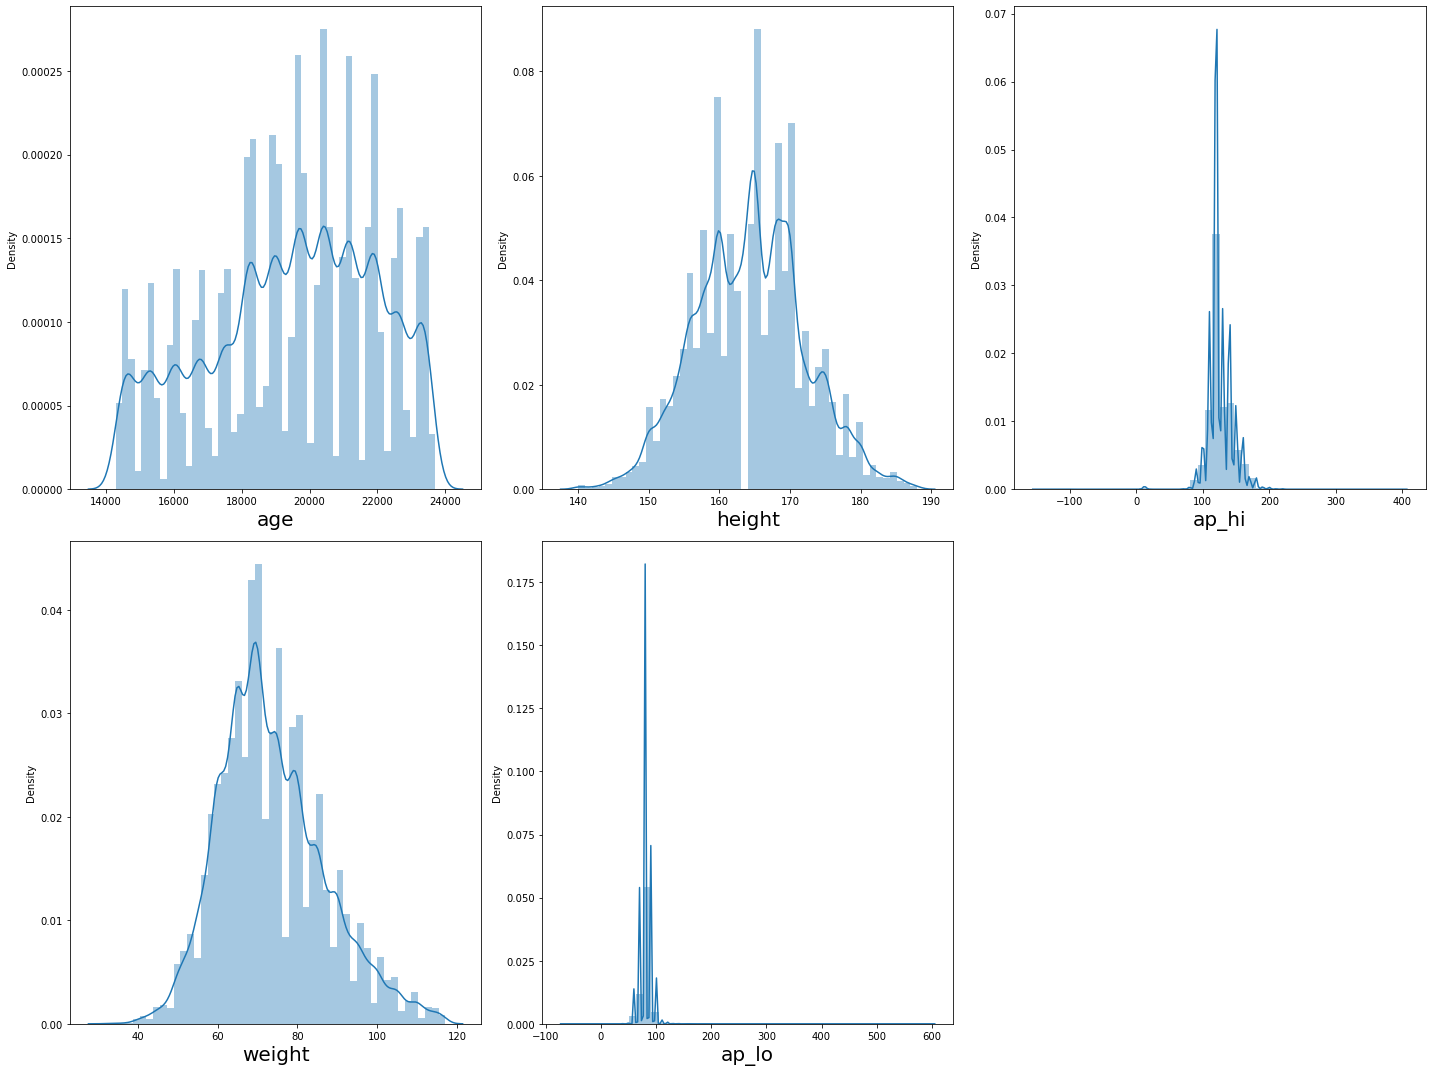

In [22]:
plt.figure(figsize=(20,15))
plotnumber=1

for column in df[['age','height','ap_hi','weight','ap_lo']]:
    if plotnumber<=6:
        ax=plt.subplot(2,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=20)
        
        
    plotnumber+=1
plt.tight_layout()
    

In [23]:
# cannot make out much from the above plots.Let build model

x=df.drop(columns=['cardio'],axis=1)
y=df['cardio']

# 1. You can use correlation matrix and plot heatmap to check for multicollinearity or correlation between all variables(Refer decision tree algo for heat map)

OR

# 2. you can use VIF to check if there is any multicollinearity(refer Logistic Regression for VIF)


# Let's Tune the parameters using GridSearchCV

In [25]:
# RandomForestClassifier

x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=.30, random_state=41)

clf=RandomForestClassifier()

params={'n_estimators':[13,15],
       'criterion':['entropy','gini'],
       'max_depth':[10,15],
       'min_samples_split':[10,11],
       'min_samples_leaf':[5,6]
       }
grd=GridSearchCV(clf,param_grid=params)
grd.fit(x_train,y_train)
print('best_params = >',grd.best_params_)

clf=grd.best_estimator_     # reinstantiating with best params
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)

rf_conf_mat= confusion_matrix(y_test,y_pred)
print('\nconf_mat=>','\n',rf_conf_mat)
print('\nAccuracy rf Normal ========>', accuracy_score(y_test,y_pred))

best_params = > {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 15}

conf_mat=> 
 [[8240 2003]
 [3366 6599]]

Accuracy rf Normal ========> 0.7343131433095804


In [26]:
report= classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75     10243
           1       0.77      0.66      0.71      9965

    accuracy                           0.73     20208
   macro avg       0.74      0.73      0.73     20208
weighted avg       0.74      0.73      0.73     20208



# Note

You can improve the performance by tweaking preprocessing methods

# Let's plot ROC AUC curve to choose best model

In [28]:
# Plot ROC/AUC for multiple models without hyperparams tuning

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import plot_roc_curve

In [29]:
lr=LogisticRegression()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()
kn=KNeighborsClassifier()

In [30]:
# Traine test split
x=df.drop(columns=['cardio'],axis=1)
y=df['cardio']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.25, random_state=41)

# training with all classifier
lr.fit(x_train,y_train)
rf.fit(x_train,y_train)
kn.fit(x_train,y_train)
dt.fit(x_train,y_train)

print("All models are trained")

All models are trained


In [31]:
# All models score captured
lr.score(x_train,y_train)
rf.score(x_train,y_train)
kn.score(x_train,y_train)
dt.score(x_train,y_train)

print("All models test score captured")


All models test score captured


# Let's check ROC AUC Curve for the fitted model

True positive rate
False positive Rate


Since it is difficult to evaluate the score based on only  TPR and FPR data, there comes AUC

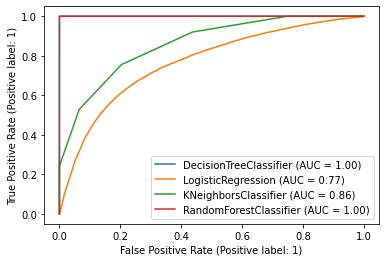

In [33]:
### How well our model works on training data

disp=plot_roc_curve(dt,x_train,y_train)
plot_roc_curve(lr,x_train,y_train,ax=disp.ax_) # ax_=Axesnwith confusion matrix
plot_roc_curve(kn,x_train,y_train,ax=disp.ax_)
plot_roc_curve(rf,x_train,y_train,ax=disp.ax_)
plt.legend(prop={'size':10},loc='lower right')
plt.show()

# How well our model works on test data

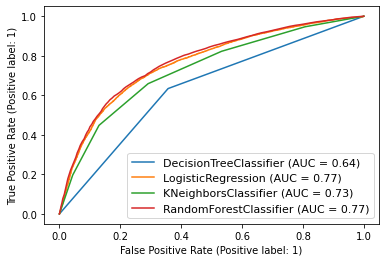

In [34]:
# How well our model works on Test data

disp=plot_roc_curve(dt,x_test,y_test)
plot_roc_curve(lr,x_test,y_test,ax=disp.ax_) # ax_=Axesnwith confusion matrix
plot_roc_curve(kn,x_test,y_test,ax=disp.ax_)
plot_roc_curve(rf,x_test,y_test,ax=disp.ax_)
plt.legend(prop={'size':11},loc='lower right')
plt.show()